In [5]:
import os
!ulimit -Sv 8000000
#!taskset -c 0,1 python

print ("Check!!")
import tensorflow as tf
import psutil
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import time
import matplotlib.pyplot as plt

# Disable GPU usage
tf.config.set_visible_devices([], 'GPU')

# Optionally disable XLA devices to prevent further warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Print CPU Count
print("CPU Count:", os.cpu_count())

Check!!
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU Count: 32


In [2]:
model_name = "gpt2"  # You can use "gpt2-medium", "gpt2-large", or "gpt2-xl" for larger versions
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

In [3]:
# Cell 3: Set Pad Token and Model to Evaluation Mode
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as the pad_token

model.eval()  # Set model to evaluation mode

# Define a prompt
prompt = "What is the capital of Denmark?"

# Encode the prompt (tokenize it) with padding
inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Ensure padding is applied if needed

# Add attention mask to the inputs
attention_mask = inputs['attention_mask']

Average Latency: 4243.38 ms


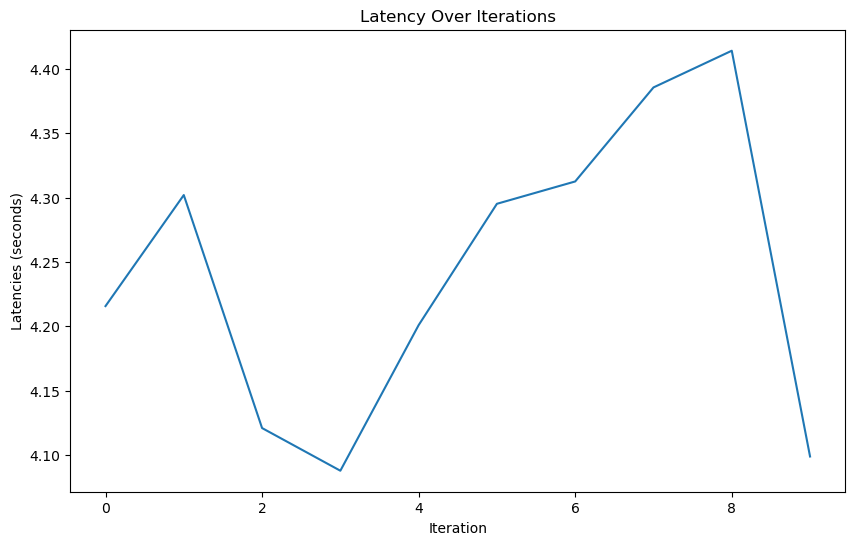

In [11]:
# Cell 4: Measure Latency Over Multiple Iterations
def measure_latency(tokenizer, model, prompt, iterations=25):
    latencies = []
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Encode the prompt with padding
    attention_mask = inputs['attention_mask']  # Get the attention mask
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        latencies.append (end_time - start_time)
    average_latency = sum(latencies) / len(latencies)
    return average_latency, latencies

# Measure and print average latency
average_latency, latencies = measure_latency(tokenizer, model, prompt)
print(f"Average Latency: {average_latency * 1000:.2f} ms")

# Plot Latency over iterations
plt.figure(figsize=(10, 6))
plt.plot(latencies)
plt.title('Latency Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Latencies (seconds)')
plt.show()

Average Throughput: 1.37 samples/second


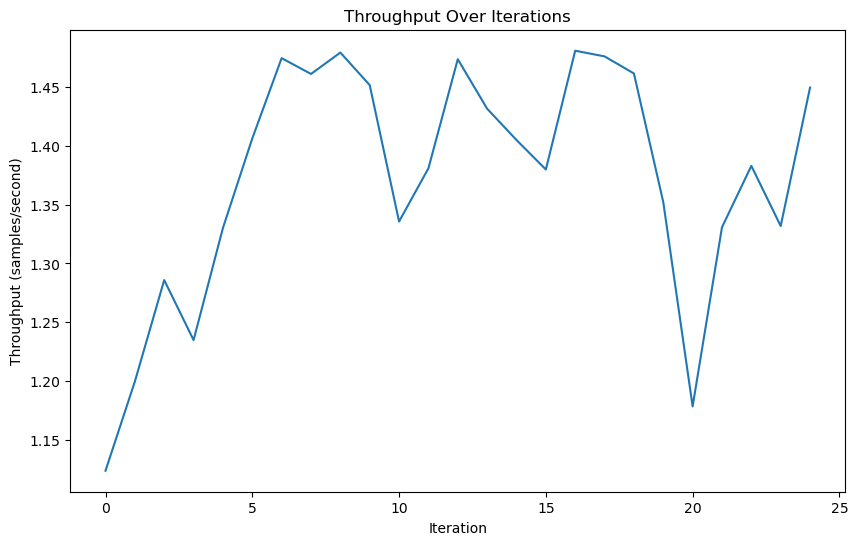

In [13]:
# Cell 5: Measure Throughput Over Multiple Iterations
def measure_throughput(tokenizer, model, prompt, batch_size=8, iterations=25):
    throughputs = []
    inputs = tokenizer([prompt] * batch_size, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
    attention_mask = inputs['attention_mask']
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        throughput = batch_size / (end_time - start_time)
        throughputs.append(throughput)
    
    average_throughput = sum(throughputs) / len(throughputs)
    return throughputs, average_throughput

# Measure and print average throughput
prompt = "Mary had a little lamb"
throughputs, average_throughput = measure_throughput(tokenizer, model, prompt)
print(f"Average Throughput: {average_throughput:.2f} samples/second")

# Plot throughput over iterations
plt.figure(figsize=(10, 6))
plt.plot(throughputs)
plt.title('Throughput Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Throughput (samples/second)')
plt.show()

Average Memory Usage: 10886.38 MB


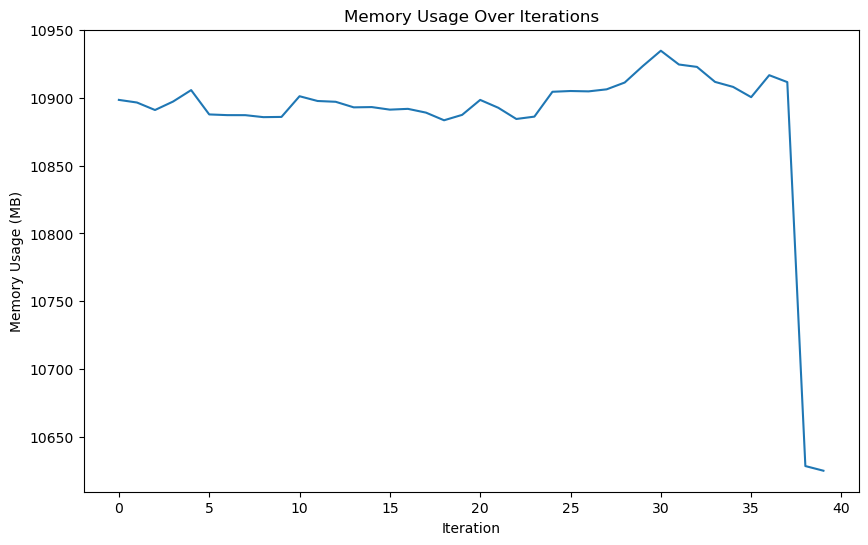

In [18]:
# Cell 6: Track Memory Usage
def get_memory_usage():
    memory = psutil.virtual_memory()
    return memory.used  # Return memory used in bytes

def track_memory_usage(model, inputs, attention_mask, iterations=25):
    memory_usages = []
    for _ in range(iterations):
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=attention_mask,  # Provide attention mask
            max_length=100,  # Maximum number of tokens to generate
            num_return_sequences=1,  # Number of output sequences
            no_repeat_ngram_size=2,  # Prevent repetition
            top_p=0.92,  # Nucleus sampling (controls randomness)
            top_k=50,  # Top-k sampling
            temperature=0.85,  # Lower temperature makes text less random
            do_sample=True,  # Enable sampling mode to use top_p, top_k, and temperature
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        memory_usage = get_memory_usage()
        memory_usages.append(memory_usage)
    
    average_memory_usage = sum(memory_usages) / len(memory_usages)
    return memory_usages, average_memory_usage

# Define inputs and attention mask
prompt = "What is the capital of Denmark and what is the capital of India?"
inputs = tokenizer(prompt, return_tensors="pt", padding=True)
attention_mask = inputs['attention_mask']

# Track memory usage over iterations
memory_usages, average_memory_usage = track_memory_usage(model, inputs, attention_mask)

# Print average memory usage
print(f"Average Memory Usage: {average_memory_usage / (1024 * 1024):.2f} MB")

# Plot memory usage over iterations
plt.figure(figsize=(10, 6))
plt.plot([usage / (1024 * 1024) for usage in memory_usages])  # Convert bytes to MB for plotting
plt.title('Memory Usage Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Memory Usage (MB)')
plt.show()


In [ ]:
import time
from datasets import load_dataset
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Define batch size
batch_size = 8

# Load dataset (choose config appropriately)
gsm8k_dataset = load_dataset("gsm8k", name="main", split="test")
math_dataset = load_dataset("math_dataset", name="algebra__linear_1d", split="test")

# Choose the dataset to use, e.g., GSM8K
dataset = gsm8k_dataset  # Or replace with math_dataset

# Example preprocessing: Extract the 'question' field for prompts (adjust field name if needed)
prompts = dataset['question'][:batch_size]  # Get a batch of prompts

# Load tokenizer and model (GPT-2 example)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

# Set padding_side to 'left' when initializing the tokenizer
tokenizer.padding_side = 'left'

# Set pad_token to eos_token (since GPT-2 doesn't have a pad_token)
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the inputs
inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)

# Check if the attention mask is included
print(inputs.keys())  # This should include 'attention_mask' and 'input_ids'

# Run the model and measure latency
start_time = time.time()
for _ in range(10):  # Run 10 iterations (adjust as needed)
    outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_new_tokens=50)  # Only generate 50 new tokens
end_time = time.time()

# Calculate throughput
throughput = (batch_size * 10) / (end_time - start_time)
print(f"Throughput: {throughput:.2f} samples/second")

# Optionally: Print model outputs
for i, output in enumerate(outputs):
    print(f"Prompt: {prompts[i]}")
    print(f"Generated Output: {tokenizer.decode(output, skip_special_tokens=True)}")